# Tweet, Tweet...Can That Bird Predict Stock Prices??

*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*


**Project Version:** Final Submission

**Due Date:** Sunday April 22, 2018

**Names:** Rebecca Rodriguez, Jorge Rodriguez

**Video Link:** https://www.youtube.com/watch?v=a2QSQLli0Pk&feature=youtu.be

## Background and Motivation

Our motivation to analyze the relationship between company tweets and stock performance stems from several different factors. As former business students (Jorge has an undergraduate degree in Economics and Statistics and Rebecca a degree in Accounting), we have always been drawn to more business-like problems that involve financial and economic data. As such, we knew we wanted to use our data science and computer science skills (we both have taken a few CS classes) to analyze a business problem from a new perspective. Additionally, we were quite intrigued by Vivek Srikumar's presentation on Natural Language Processing (NLP), and decided to apply NLP tools to a business problem. Hence our idea was born to use NLP to analyze the tweets of four companies (Dr. Pepper, Monster Energy, Coca Cola and Pepsi) and determine whether the sentiment of the tweets are in any way related to the stock performance of each company. 


## Project Objectives

Questions we are trying to answer:

1. What are the results of using NLP (sentiment analysis) on company tweets for a given time frame? Are the majority of tweets from date X to date Y positive or negative?
2. Are the sentiments of tweets related to the stock performance of a company? e.g. if most tweets are positive, is stock performing well?
3. What relationship exists among tweet sentiment, tweet users and stock performance, if any? 

Benefits:

1. We applied many of the data science tools and techniques (data collection, data cleaning, regression analysis, data visualizaion) that we have learned over this semester to an interesting topic.

2. We have gained a deeper understanding of Python’s libraries and packages for NLP and sentiment analysis, as well as its more advanced data management and visualization capabilities.

3. We gained first-hand experience on designing and implementing a data pipeline from data sources “in the wild” to clean data in data frames.

5. We developed a regression model for predicting the performance of stock based on the sentiment of company tweets and Twitter user attributes.



## Data Collection

The data gathering process is provided in two separate notebooks. Please refer to the [tweet retrieval code](Data Project - Tweet Retrieval.ipynb) and [stock retrieval code](DataProject_Financial_Data.ipynb) for more details.


## Data Cleaning

Once all of the data was gathered and saved as CSV files, we created several Pandas data frames to hold the data for ease of processing and analysis. 

In [1]:
#imports
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import re
import glob
import os
import nltk
from sklearn.model_selection import train_test_split
from nltk import NaiveBayesClassifier
from nltk import classify
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import digits
import seaborn as sns
import wordcloud   #must be downloaded through Anaconda
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')
nltk.download('punkt')

#autocomplete
%config IPCompleter.greedy=True

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Becca\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Becca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We created 3 separate dataframes for each company: one to hold tweet data (tweet text, ID, etc.), a second to hold user data (followers, friends, etc.), and a third to hold entity data (links, urls). (Note: ultimately we decided not to use entity data.) For ease of use, we stored the dataframes in 3 dictionaries, with company names as keys and dataframes as values. 

In [3]:
# CREATE DF FOR EACH COMPANY'S OBJECTS (4 companies, 3 objects each = 12 dfs)

#combine csv's into list of csv's
path1 = r'TweetDataCSV\TweetFiles' 
path2 = r'TweetDataCSV\UserFiles' 
path3 = r'TweetDataCSV\EntityFiles'

companies = ['coke', 'drp', 'monst', 'pepsi']

#create dict to hold csv files for all comps
#tweets
co_tweets = {}
for co, i in zip(companies, range(len(companies))):
        co_tweets[co+"_tweets"]= glob.glob(os.path.join(path1, "*"+companies[i]+".csv"))        
#users
co_users = {}
for co, i in zip(companies, range(len(companies))):
        co_users[co+"_users"]= glob.glob(os.path.join(path2, "*"+companies[i]+".csv"))        
#entities
co_entities = {}
for co, i in zip(companies, range(len(companies))):
        co_entities[co+"_entities"]= glob.glob(os.path.join(path2, "*"+companies[i]+".csv"))


#for each key in dict, make a df of each item in value (key is a company, value is a list, item is a csv file)
#tweets
dflist_cotweets = {}
for key in co_tweets:
    dflist_cotweets[key] = []
    for item in co_tweets[key]:
        df = pd.read_csv(item, names=['TweetID', 'TweetText', 'Retweets', 'Favorited', 'Date', 'Popularity', 'UserID', 'CompTag'], 
                    encoding = "ISO-8859-1")
        dflist_cotweets[key].append(df)
#users
dflist_cousers = {}
for key in co_users:
    dflist_cousers[key] = []
    for item in co_users[key]:
        df = pd.read_csv(item, names=['UserID', 'Followers', 'Friends', 'NumTweets', 'URL', 'CompTag'], 
                    encoding = "ISO-8859-1")
        dflist_cousers[key].append(df)
#entities
dflist_coentities = {}
for key in co_entities:
    dflist_coentities[key] = []
    for item in co_entities[key]:
        df = pd.read_csv(item, names=['Hashtags', 'URLs', "TweetID", 'CompTag'], encoding = "ISO-8859-1")
        dflist_coentities[key].append(df)

#list of company object dicts
list_codflists = [dflist_cotweets, dflist_cousers, dflist_coentities]


#for each co (key), combine all in dflist (value) into one df
#tweets
tweetdfs = {}
for key in dflist_cotweets:
    tweetdfs[key] = pd.DataFrame()
    tweetdfs[key] = pd.concat(dflist_cotweets[key], ignore_index=True)    
#users
userdfs = {}
for key in dflist_cousers:
    userdfs[key] = pd.DataFrame()
    userdfs[key] = pd.concat(dflist_cousers[key], ignore_index=True)
#entities
entitydfs = {}
for key in dflist_coentities:
    entitydfs[key] = pd.DataFrame()
    entitydfs[key] = pd.concat(dflist_coentities[key], ignore_index=True)


In [5]:
# CREATE KEYS AND VISUALLY INSPECT DF'S

#list of keys in df dicts
dfkeys_tweets = list(tweetdfs.keys())
dfkeys_users = list(userdfs.keys())
dfkeys_entities = list(entitydfs.keys())

# print(dfkeys_tweets)
# #look at head of dfs
for key in dfkeys_tweets:
    print(tweetdfs[key].head())
    
# for key in dfkeys_users:
#     print(userdfs[key].head())

# for key in dfkeys_entities:
#     print(entitydfs[key].head())

              TweetID                                          TweetText  \
0  979156368073592832  @CocaCola Looks Like Little Buddy Got Real COK...   
1  979155634561212417  @CocaCola Peach is the best thing to ever happ...   
2  979153614886395905  Congratulations to the @HindsCC All-Mississipp...   
3  979153219636158464  R2i: https://t.co/K1vFEa851H  - Amplify your h...   
4  979151456015175680  @CocaCola lookin 4 Lindsey bert from furman wa...   

   Retweets  Favorited                            Date Popularity  \
0         0          0  Thu Mar 29 00:40:44 +0000 2018     recent   
1         0          0  Thu Mar 29 00:37:49 +0000 2018     recent   
2         0          1  Thu Mar 29 00:29:48 +0000 2018     recent   
3         0          0  Thu Mar 29 00:28:14 +0000 2018     recent   
4         0          0  Thu Mar 29 00:21:13 +0000 2018     recent   

               UserID CompTag  
0  896492660999020544     NaN  
1          3296949962     NaN  
2          2407736562     NaN  


After visually inspecting the dataframes, we noticed several duplicates. Here we removed them based on date, user ID and tweet ID. 

In [6]:
# REMOVE DUPLICATE ENTRIES FROM DF'S

for key in dfkeys_tweets:
    tweetdfs[key].drop_duplicates(subset="Date", inplace=True)
    tweetdfs[key].index = range(tweetdfs[key].shape[0]) #reindex df

for key in dfkeys_users:
    userdfs[key].drop_duplicates(subset="UserID", inplace=True)
    userdfs[key].index = range(userdfs[key].shape[0]) #reindex df
    
for key in dfkeys_entities:
    entitydfs[key].drop_duplicates(subset="TweetID", inplace=True)
    entitydfs[key].index = range(entitydfs[key].shape[0]) #reindex df


The first step in cleaning the tweet text involved removing unnecessary symbols including '@' and '#'. We also made a version that would remove the name after the '@' in order to prevent company names from being classified in our classifier below. 

In [7]:
# CLEAN TWEET TEXT

#function to clean tweet text by removing links and special characters
def clean_tweet(tweet):
    #remove @ but keep handle name
    return ' '.join(re.sub("(@)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
#     #remove @ and handle name
#     return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

#apply tweet cleaner to all tweets
for key in dfkeys_tweets:
    tweetdfs[key]["TweetText"] = tweetdfs[key]["TweetText"].apply(clean_tweet)


In order to train and test our Bayes classifier, we needed to create a "corpus" of tweets and corresponding sentiments. We read through hundreds of tweets and classified 100 of them, 20 from each company. I would have never in a million years guessed how much people LOVE the taste of Dr. Pepper. I'm still shocked. 

In [9]:
# MANUALLY CLASSIFY TWEETS

##here we create a set of classified tweets--we'll use it when training our Bayes Classifier

#grab the tweet text of all tweets
coke_tweets = tweetdfs[dfkeys_tweets[0]]['TweetText']
drp_tweets = tweetdfs[dfkeys_tweets[1]]['TweetText']
monst_tweets = tweetdfs[dfkeys_tweets[2]]['TweetText']
pepsi_tweets = tweetdfs[dfkeys_tweets[3]]['TweetText']

#view tweets to classify
# for item in tweetdfs['coke_tweets']['TweetText']:
#     print (item)

#classify a few tweets as negative or positive
classified_coke_tweets = [("ReduceReuseRecycle PlasticKILLS CocaCola ShameOnYou No more plastic", "neg"),
         ("I ve gotten alot bettter about the amount of CocaCola I drink but when I m stressing that is the only damn thing I want Breakfast lunch and dinner", "pos"),
         ("Wtf Arbys Now serving CocaCola products", "neg"),
         ("Excited to be working with CocaCola this weekend at WFFColumbus TourneyTown at cbusconventions WFinalFour", "pos"),
         ("CocaCola ajc Love it so MUCH After I drank the entire bottle I grew a garden Cocacola", "pos"),
         ("Believe it or not I am a fan of CocaCola I know this isn t the biggest collection you ve ever seen I can t afford to buy everything I want", "pos"),
         ("CocaCola Peach is the best thing to ever happen to me why is it only available in Japan", "pos"),
         ("CocaCola I m still disappointed that green Coke went away as well", "neg"),
         ("your commercials are terrible", "neg"),
         ("Love it so MUCH After I drank the entire bottle I grew a garden Cocacola", "pos"),
         ("Good for them but that stuff is really terrible for you", "neg"),
         ("Any reason that the new Feisty Cherry Diet Coke burns your throat", "neg"),
         ("Not enough Lime not enough Ginger Amp them up", "neg"),
         ("I m gonna need you to step up your game and bring back PepsiTwist and PepsiBlue because is beating you guys with their new GeorgiaPeachCoke flavor", "neg"),
         ("Taking home the unchanged and unbeaten taste of since 1886", "pos"),
         ("It s a sad sight This is Grand Union Canal last week There were worse photos", "neg"),
         ("I always used to joke Dasani was just ass water and my wife refused to believe me guess it s proof now you re only after the uh bottom line", "neg"),
         ("Thank you for helping me get through my work day Couldn t do it without you", "pos"),
         ("I swear I could single handedly keep Diet Coke running", "pos"),
         ("CocaCola living the life ShareACocaCola", "pos")]

classified_drp_tweets = [("Watching a documentary on Pepsi vs Coke Interesting to be sure But my loyalty will always be to", "pos"),
        ("neticall drpepper DietDrPepper I really don t like the taste of aspartame", "neg"),
        ("7th Diet Dr Pepper tonight MatPatGT I have an addiction Psst drpepper plz sponsor my addiction", "pos"),
        ("Boy I tell you what we better not have that problem Would be such a disappointment to this society drpepper", "neg"),
        ("3 PepperPack Ambassador DrPepper TheOneYouCrave", "pos"),
        ("TSMViss drpepper Dude nice Love me some dr pepper Seriously though thats the greatest soda ever made APPRECIATE ITS DIVINE TASTE", "pos"),
        ("drpepper I expect this from RC Cola but not from you", "neg"),
        ("So who do I have to talk to have my mini fridged stocked with only drpepper That would be a dream come true", "pos"),
        ("Time to stop work for the day and settle down with a glass of Captain Pepper Brought to you by CaptainMorgan and drpepper Obsessed with drpepper", "pos"),
        ("drpepper stop with the lil sweet bullshit You can t harass people into buying a product", "neg"),
        ("I could go for an ice cold drpepper right about now", "pos"),
        ("So why does Schweppes drpepper Sevenup put high fructose corn syrup in their tonic water Sodium Benzoate mixed with Citric Acid is bad for human consumption Please take out Thank You GMOFreeUSA GMOFreeNJ Cornucopia Inst OrganicLife", "neg"), 
        ("Here s how tacobell NikonUSA and drpepper are giving to get back by using scholarships as a marketing tool", "pos"),
        ("Thanks drpepper for the hand written letter and free drinks you guys are amazing and thanks TeamSoloMid", "pos"),
        ("drpepper what the hell was that ad I just saw A whitewashed white Prince No No no no Prince was a black man He was amazing Please discontinue this ad Hire someone to read your ads for racism a sensitivity reader", "neg"),
        ("My pepperpack came in today I m proud to be an ambassador for drpepper", "pos"),
        ("a Dr Pepper truck cut me off in traffic so congratulations drpepper you lost your most loyal consumer", "neg")]

classified_monst_tweets = [("MyDrinkOrderWouldBe A MonsterEnergy Ultra with grenadine Also known as Temple of The Monster kitchenwench45", "pos"),
          ("I just want to get sponsored by MonsterEnergy to just drink and enjoy their delicious nectar of the Gods I ll be a walking billboard idc Don t me with negativity", "pos"),
          ("The white MonsterEnergy still reigns king in my book sugarfree energy", "pos"),
          ("GiggityGopher I just want a MonsterEnergy sponsorship I live off of their juicy goodness", "pos"),
          ("Retweet if you MonsterEnergy Supercross SXonFOX DropTheGate SupercrossLIVE", "pos"),
          ("We re returning to the road NEXT MONTH and can t wait to see you Knuckleheads again MonsterEnergy For dates tickets VIP info", "pos"),
          ("Could someone please deliver 15 sugar free MonsterEnergy to my desk", "pos"),
          ("leonryouknow MonsterEnergy That don t work on me anymore", "neg"),
          ("How do people drink MonsterEnergy drinks I ve tried about 6 different ones and they all taste like literal ass", "neg"),
          ("I m never drinking monsterenergy ever again had the most fucked up sleep ever woke up from the", "neg"),
          ("I stopped buying MonsterEnergy when the first news of this hit Way to give business to competitors Just like ncgop ncchamber torched a 20 year relationship I had with BurtsBees over their hate laws like HB2 badforbiz", "neg"),
          ("Congratulations on the extension NASCAR and MonsterEnergy Great news for the sport today Just hope MonsterEnergy decides to stick around in some capacity after the 2019 season NASCAR", "pos"),
          ("Tryina work but can t concentrate Required chocolate and MonsterEnergy BusinessExpenses", "pos"),
          ("RealJoltCola Your cola sucks MonsterEnergy for life", "pos"),
          ("selasdad8 ClintBowyer MonsterEnergy NASCAR Thank God Im sick of seeing the monster girls They care more about looking good on camera than they do about the sport Move on and good riddance stuckup snotty fake", "neg"),
          ("Stay tuned for an awesome project we are filming this week with ryan villopoto2 125 450 What do you want to see TheGuysThatRide YamahaMotorUSA procircuit78 MonsterEnergy ansrmx", "pos"),
          ("good to know MonsterEnergy Is capable of making shittier caffeinated gatorade", "neg"),
          ("JeremyMcGrath RazorWorldwide MonsterEnergy KawasakiUSA spyoptic MAXXISTIRESPK maxxistires Oh I like that peak cr125", "pos"),
          ("FordPerformance VaughnGittinJr ChelseaDeNofa FormulaDrift NittoTire MustangRTR Ford MonsterEnergy Excited to watch this", "pos"),
          ("NASCAR MonsterEnergy THROUGH 2019 HAHAHAHAHA THIS SPORT IS SUCH A PATHETIC JOKE", "neg")]

classified_pepsi_tweets = [("pepsi Pepsi where do you get your statistics from lol your ads are super funny", "pos"),
          ("pepsi PepsiCoDeals Why are you putting Aspartame back in diet Pepsi", "neg"),
          ("pepsi can find Diet Pepsi with Classic Sweetener ANYWHERE Is it going away My wife loves it and we are constantly looking for the cans when we go to stores but there s never any there", "neg"),
          ("I drink it and they pay me in my peteypablo voice lol pepsi IndraNooyi Pepsi is the beverage of the new wave music and urban culture movement", "pos"),
          ("Tomorrow morning catch me on 97 x talking about SandJamFest in Visit PCB sponsored by pepsi JordanZeh", "pos"),
          ("SimoneGiertz MakitaTools Ugh how embarrassing MakitaTools probably hired the people too tone deaf to work in pepsi s marketing dept", "neg"),
          ("I wish every restaurant and fast food would have both pepsi and CocaCola products agirlcandream", "pos"),
          ("netflix FoxNews nfl Disney Pepsi CokeZero NO AMOUNT of support for ANY leftist statist socialist America hating sub human scumbag is acceptable", "neg"),
          ("I am sorry BradJakeman blames the failure of the KendallJenner pepsi ad on a divided society the mainstream media vocal minorities social media and inadequate tools How about lack of common sense AdweekChat", "neg"),
          ("2 packs of MountainDew and 2 packs of pepsi My Mommy loves me", "pos"),
          ("Well pepsi has admitted to having cancer causing chemicals in their drink Never again", "neg"),
          ("pepsi Diet Pepsi it s what s in my veins", "pos"),
          ("I ve decided to boycott Nestle CocaCola amp pepsi for ruining our natural water systems You all should watch the film Flow", "neg"),
          ("If you haven t checked out the AWESOME stuff you can get right now with your pepsi Stuff points go see It s a blast from the past that you ll definitely want for yourself Head on over to to submit your points and get your stuff", "pos"),
          ("Anyone else think pepsi is lying about their same great taste crap I ve been drinking Pepsi since the womb guys it for sure taste different", "neg"),
          ("pepsi I am willing to bet you have a lot of that newer DietPepsi collecting dust In case the obvious sell out of Diet Pepsi Classic wasn t a business indicator here s a tip Diet Pepsi was great before BringItBack IfIWantedFlatTheresDietCoke ConsumersSay", "neg"),
          ("Thank you to our wonderful sponsors pepsi LIFEWTR Fritolay and DonutFriend We are so grateful for the wonderful support of Education Through Music Los Angeles s 8th Annual Music Unites the World Festival thankyou support smilesallround", "pos"),
          ("Happy to report that I have not had pepsi or CocaCola or other soft drinks in over 20 years even when I was 16 19 years old and worked at RegalMovies where it was free to employees Because that stuff is nasty", "neg"),
          ("While out for a walk I came across this Pepsi can The can s retro appearance coupled with this perfect sunny weather was just the nostalgic litter I needed to put me in great spirits I hope the can design never changes back Nostalgia Garbage GoodVibes Pepsi", "pos"),
          ("superspectral pepsi Don t really like the new formula Could do without the ace k Won t be returning to my one a day habit Way to go pepsi", "neg")]

After experimenting with several classifiers in both class lectures and homeworks, we decided to use the Naive Bayes Classifier to classify the tweet sentiments as either positive or negative. From our corpus, we split the data into training and testing sets, and proceeded to train our Bayes classifier. The accuracy of our classifier was actually quite dismal, coming in at a whopping 30%. So, we were actually misclassifying tweets! Since our project objectives did not include optimally training a classifier, we continued with our analysis. 

In [10]:
# TRAIN AND TEST NAIVE BAYES CLASSIFIER (this takes about 20-30 minutes)

#Step 1: Train the data
#split data into training and testing sets
training_set = classified_coke_tweets[:16] + classified_drp_tweets[:16] + classified_monst_tweets[:16] + classified_pepsi_tweets[:16]
test_set = classified_coke_tweets[16:] + classified_drp_tweets[16:] + classified_monst_tweets[16:] + classified_pepsi_tweets[16:]

#Step 2: Make dictionary of tokenized tweets
all_words = set(word.lower() for passage in training_set for word in word_tokenize(passage[0]) if word.isalpha())
all_words_test = set(word.lower() for passage in test_set for word in word_tokenize(passage[0]) if word.isalpha())

#Step 3: Construct data to feed to classifier
t = [({word: (word in word_tokenize(x[0])) for word in all_words}, x[1]) for x in training_set]
t_test = [({word: (word in word_tokenize(x[0])) for word in all_words_test}, x[1]) for x in test_set]
  
#Step 4: Train classifier with training data
classifier = NaiveBayesClassifier.train(t)
  
#Step 5: Test classifier on test set
print("Naive Bayes Accuracy:", classify.accuracy(classifier, t_test))

#Step 6: Use classifier to classify all tweets
all_tweets = pd.Series()
all_tweets = all_tweets.append([coke_tweets, drp_tweets, monst_tweets, pepsi_tweets])
sentiments = []

for tweet in all_tweets:
    features = {word.lower(): (word in word_tokenize(tweet.lower())) for word in all_words if word.isalpha()}
    sentiments.append(classifier.classify(features))


#Resources:
#http://opensourceforu.com/2016/12/analysing-sentiments-nltk/
#https://pythonprogramming.net/naive-bayes-classifier-nltk-tutorial/
#http://textminingonline.com/dive-into-nltk-part-vii-a-preliminary-study-on-text-classification

Naive Bayes Accuracy: 0.3076923076923077


In [11]:
# ADD SENTIMENTS TO DF

#create series of sentiments
coke_sentiments = pd.Series(sentiments[:len(coke_tweets)])
drp_sentiments = pd.Series(sentiments[len(coke_tweets):len(drp_tweets)+len(coke_tweets)])
monst_sentiments = pd.Series(sentiments[len(drp_tweets)+len(coke_tweets):len(monst_tweets)+len(drp_tweets)+len(coke_tweets)])
pepsi_sentiments = pd.Series(sentiments[len(monst_tweets)+len(drp_tweets)+len(coke_tweets):])

#add tweet sentiments to corresponding dfs
tweetdfs[dfkeys_tweets[0]]['TweetSentiment'] = coke_sentiments
tweetdfs[dfkeys_tweets[1]]['TweetSentiment'] = drp_sentiments
tweetdfs[dfkeys_tweets[2]]['TweetSentiment'] = monst_sentiments
tweetdfs[dfkeys_tweets[3]]['TweetSentiment'] = pepsi_sentiments


## Visualizing Tweets

Our initial data exploration involved visualizing the tweet text. We created word clouds to see the most frequently occuring words in both positive and negative tweets.

Positive coke_tweets : top 20 words 
 [('cocacola', 1310), ('coke', 154), ('amp', 107), ('pepsi', 105), ('get', 78), ('cola', 77), ('coca', 74), ('like', 68), ('new', 60), ('would', 59), ('love', 58), ('drink', 57), ('one', 50), ('please', 48), ('sugar', 47), ('cocacolaco', 46), ('see', 44), ('today', 41), ('us', 40), ('day', 40)] 

Positive drp_tweets : top 20 words 
 [('drpepper', 741), ('pepper', 132), ('dr', 126), ('myth', 72), ('one', 58), ('get', 57), ('daequan', 56), ('bellsinequality', 49), ('jeanniedvm', 49), ('slaukers', 49), ('dwyerellen', 49), ('theoldsquid', 49), ('tiacarra', 49), ('charmantmaries', 49), ('kirk', 49), ('bridgers', 49), ('garydubya', 49), ('laineymel', 49), ('blacksherbert', 49), ('readthenprocede', 49)] 

Positive monst_tweets : top 20 words 
 [('monsterenergy', 1151), ('nascar', 209), ('monster', 112), ('get', 105), ('via', 100), ('motogp', 89), ('youtube', 85), ('energy', 74), ('see', 66), ('alpinestars', 64), ('ducatimotor', 62), ('shark', 61), ('helmet

(-0.5, 399.5, 199.5, -0.5)

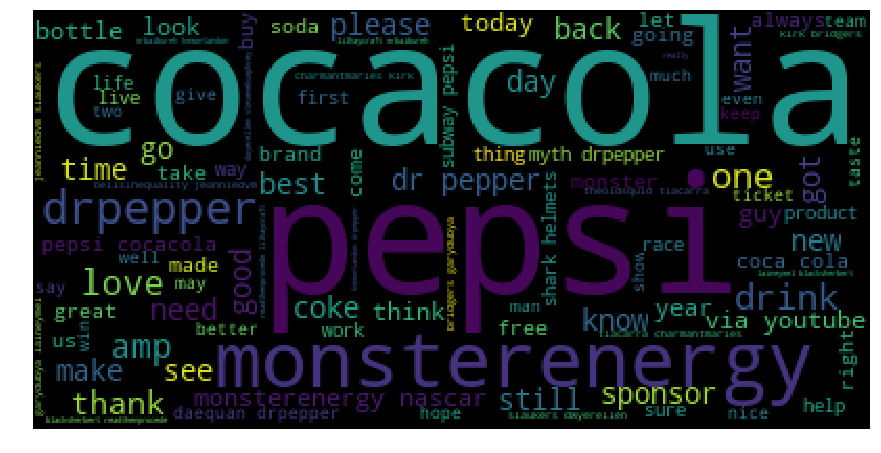

In [12]:
# VISUALIZE FREQUENCY OF WORDS IN POSITIVE TWEETS

#format positive tweets for visualizations
pos_words_all = []
pos_word_freq = []
for key in dfkeys_tweets:
    #combine all tweets into one string
    tolist = tweetdfs[key][tweetdfs[key]['TweetSentiment']=='pos']['TweetText'].tolist()
    joined = '-'.join(tolist)
    #set stop words and tokenize string
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(joined)
    postweets = nltk.Text(tokens)
    postweets = [w.lower() for w in postweets if w.isalpha()]
    postweets = [i for i in postweets if i not in stop_words]
    pos_words_all.append(postweets)
    #get frequency of words
    freq = nltk.FreqDist(postweets)
    #look at top 20 words for each company's positive tweets
    print("Positive", key , ": top 20 words \n", freq.most_common(20), "\n")
    pos_word_freq.append(freq.most_common(20))
    
#create word cloud of top 100 words in positive tweets
flat_list = [item for sublist in pos_words_all for item in sublist]
wordcloud = WordCloud(background_color="black", max_words=100, max_font_size=300, random_state=15)
wordcloud.generate('-'.join(flat_list))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')

In [ ]:
# VISUALIZE FREQUENCY OF WORDS IN NEGATIVE TWEETS

#format positive tweets for visualizations
neg_words_all = []
neg_word_freq = []
for key in dfkeys_tweets:
    #combine all tweets into one string
    tolist = tweetdfs[key][tweetdfs[key]['TweetSentiment']=='neg']['TweetText'].tolist()
    joined = '-'.join(tolist)
    #set stop words and tokenize string
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(joined)
    negtweets = nltk.Text(tokens)
    negtweets = [w.lower() for w in negtweets if w.isalpha()]
    negtweets = [i for i in negtweets if i not in stop_words]
    neg_words_all.append(negtweets)
    #get frequency of words
    freq = nltk.FreqDist(negtweets)
    #look at top 20 words for each company's positive tweets
    print("Negative", key , ": top 20 words \n", freq.most_common(20), "\n")
    neg_word_freq.append(freq.most_common(20))
    
#create word cloud of top 100 words in positive tweets
flat_list = [item for sublist in neg_words_all for item in sublist]
wordcloud = WordCloud(background_color="black", max_words=100, max_font_size=300, random_state=15)
wordcloud.generate('-'.join(flat_list))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')

We made a few interesting observations after reviewing the most frequently occuring words: 
- Words we intuitively associate with positive or negative sentiment (e.g. 'good', 'great', 'horrible', 'bad') were not used much at all in tweets. This suggests that tweet sentiment is determined not just through words, but through context and additional information like links or pictures.
- We see a few Twitter handles in the top 20. This might indicate some sort of relationship between the tweeter and sentiment of tweet. 
- There are words that frequently appear in positive tweets that clearly should be negative (and vice versa). This could be a result of our poor performing Bayes Classifier (remember, it was only at 30% accuracy), or a lack of context. 

### Data Clean-up and Analysis

Our original intention was to treat a company's stock price as a discrete dependent variable and a combination of Tweet attributes as independent variables within a logistic regression model. This meant that for each Tweet posted we would need to have an associated change in stock price, ie observation of our dependent variable.

After collecting the Tweets though we realized that our financial data could not be granualized to the level of our Tweets; Tweet posts are recorded on Twitter on a minute:second scale, while stock prices could only be measured down to 15 minute intervals. Further complicating the problem, due to connectivity issues with Twitter's servers, and Twitter users' posting patterns, the time frames from which our Tweets were gathered spanned the entire 24 hours of the day. In contrast, our financial data was limited to the opening and closing of the stock market, Eastern Standard time.

As a solution to this problem, we opted to instead to measure the proportion of Tweet attributes per day and treat the day's change in stock price as the dependent variable, providing us with one observation for the dependent variable for each observation of the independent variables. Mathematically speaking, we have the following formulation for our dependent and independent variables.

$$Y_i \sim Bin(p_i)$$

$$X_o := proportion\ of\ postive\ Tweets\ within\ a\ day$$

$$X_1 := proportion\ of\ popular\ users\ within\ a\ day$$

$$X_2 := proportion\ of\ active\ users\ within\ a\ day$$

$$X_i \in [0,\ 1],\ i=\{0, 1, 2\}$$

 
We define a Tweet to be "positive" if it is categorized as positive by our Naive Bayesian text classifier

We define a user to be "popular" if they are within the 75 percentile of users with the most followers.

We define a user to be "active" if they are within the 75 percentile of users with the most Tweets posted.

### From "raw data" to "tidy data"

After we have retrieved our raw data from Twitter, we begin the process of converting it into "tidy" data for downstream analysis. This processes will make heavy use of Pandas dataframe manipulation capabilities, including its ability to treat dataframes as tables within a relational database system. 

To aid in the process we construct the following functions:

`get_tidy()`: for converting a company's tweet and user information into a tidy dataframe

`t_split()`: for splitting a company's tidy dataframe into Xtrain and Ytrain subsets

`get_tidy_price()`: for converting a company's stock price information into a tidy dataframe

`tidy_prop()`: for aggragating a company's tweet and user attributes into daily proportions

In [11]:
# the coke_tweet_df and coke_user_df are used a dummy variables for the function

def get_tidy(coke_tweet_df, coke_user_df):
    
    # add binary variable for positive or negative sentiment

    coke_tweet_df['sent'] = np.where(coke_tweet_df['TweetSentiment']=='pos', 1, 0)

    # we define a function for converting Tweet date to Python readable time-stamp

    def timeS(date):
        stamp = time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(date,'%a %b %d %H:%M:%S +0000 %Y'))
        return(stamp)

    # we apply our function to the 'Date' to create a time_stamp column in our tweet dateframes

    coke_tweet_df['time_stamp'] = coke_tweet_df['Date'].apply(timeS)
    
    # We now trim our tweet_df's to include only "TweetID", "UserID", "sent", and "time_stamp"

    coke_tweet_df = coke_tweet_df[["TweetID", "UserID", "sent", "time_stamp"]]
    
    # We set the threshold to categorize a user as "popular" if "Followers" is above the .75 quantile for all users
    # We set the threshold to categorize a user as "active" if "NumTweets" is above the .75 quantile for all users

    coke_f_q = coke_user_df['Followers'].quantile(q=.75)
    coke_nt_q = coke_user_df['NumTweets'].quantile(q=.75)
    
    # We create a binary variable for each user to define if they are "popular" and if they are "active"

    coke_user_df['plr'] = np.where(coke_user_df['Followers'] > coke_f_q, 1, 0)
    coke_user_df['act'] = np.where(coke_user_df['NumTweets'] > coke_nt_q, 1, 0)
    
    # We reduce our user df's to the desired variables of "UserID", "pop", and "act"

    coke_user_df = coke_user_df[['UserID', 'plr', 'act']]
    
    # We merge our tweet_df's and our user_df's over the "UserID" column to create our "tidy" df

    coke_tidy_df = coke_tweet_df.merge(coke_user_df, on="UserID")
    
    # We rearrange the columns to group our binary variables together

    coke_tidy_df = coke_tidy_df[['TweetID', 'UserID', 'time_stamp', 'sent', 'plr', 'act']]
    
    # We split the time stamp into "Day" and "Time"

    coke_tidy_df['Day'] = coke_tidy_df['time_stamp'].values.astype('<M8[D]')
    coke_tidy_df['Time'] = pd.DatetimeIndex(coke_tidy_df['time_stamp']).time
    
    # We trim our df's to include "day", "time", and the binary variables only

    coke_tidy_df = coke_tidy_df[['Day', 'Time', 'sent', 'plr', 'act']]
    
    return(coke_tidy_df)

In [12]:
def t_split(drink_tidy_df):    
    
    # we assign our X to the drink_tidy_df
    X = drink_tidy_df
    
    # we create a dummy y variable
    m = drink_tidy_df.shape[0]
    y = np.zeros(m)

    XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1)
    
    return(XTrain, XTest)


In [13]:
def get_tidy_price(price_df):
    
    # we apply our function to the 'Date' to create a time_stamp column in our tweet dateframes

    price_df['Day'] = price_df['date'].apply(pd.to_datetime)
    
    # We now trim our price_df to include 'Day' and 'Dif' only

    price_df = price_df[['Day', 'Dif']]
    
    return(price_df)

In [14]:
def tidy_prop(drink_tidy_df):
    
    drink_prp = drink_tidy_df.groupby('Day')['sent','plr','act'].sum()
    drink_prp['counts'] = drink_tidy_df.groupby('Day')['Day'].count()
    
    drink_prp['Sent_Prop'] = drink_prp.apply(lambda row: row.sent / row.counts, axis=1)
    drink_prp['Pop_Prop'] = drink_prp.apply(lambda row: row.plr / row.counts, axis=1)
    drink_prp['Act_Prop'] = drink_prp.apply(lambda row: row.act / row.counts, axis=1)

    # We tidy our df's to show only the desired proportion values

    drink_prp = drink_prp[['Sent_Prop', 'Pop_Prop', 'Act_Prop']]

    drink_prp.reset_index(level=0, inplace=True)
    
    return(drink_prp)

For each company we create the {XTest, yTest} and {Xtrain, yTrain}. We also explore the changes in proportion for postive vs negative tweet, and for popular and active user vs non-popular and non-active users.

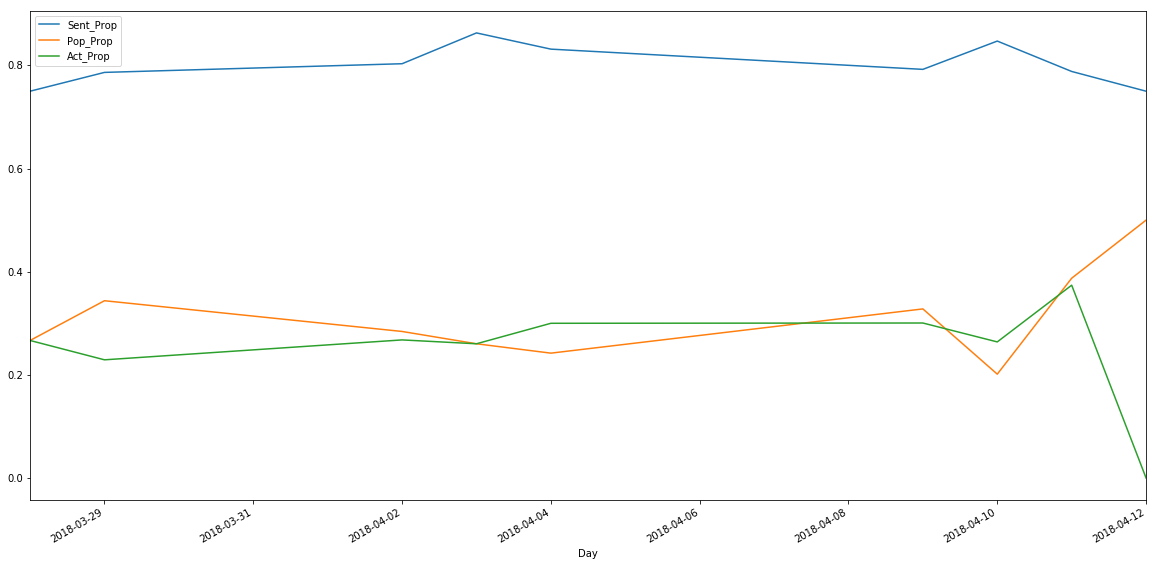

In [16]:
# Coke
coke_tweet_df = tweetdfs[dfkeys_tweets[0]]
coke_user_df = userdfs[dfkeys_users[0]] 

coke_tidy_data = get_tidy(coke_tweet_df, coke_user_df) 

Train_coke, Test_coke = t_split(coke_tidy_data)

# we aggragate our observations into daily proportions 

Train_coke_prp = tidy_prop(Train_coke)
Test_coke_prp = tidy_prop(Test_coke)

# we generate our yTrain and yTest and add them to our final df

coke_price_df = pd.read_csv("coke_price.csv")
coke_tidy_price = get_tidy_price(coke_price_df)

Train_coke_final = pd.merge(Train_coke_prp, coke_tidy_price, on='Day', how='inner')
Test_coke_final = pd.merge(Test_coke_prp, coke_tidy_price, on='Day', how='inner')

Train_viz = Train_coke_final[['Day', 'Sent_Prop', 'Pop_Prop', 'Act_Prop']].copy()
Train_viz.plot(x='Day', figsize=(20,10))

A visual inspection of the graph would indicate an inverse relationship between the number of active user and the proportion of sentiment tweets. To further investigate, we generate a correlation matrix.

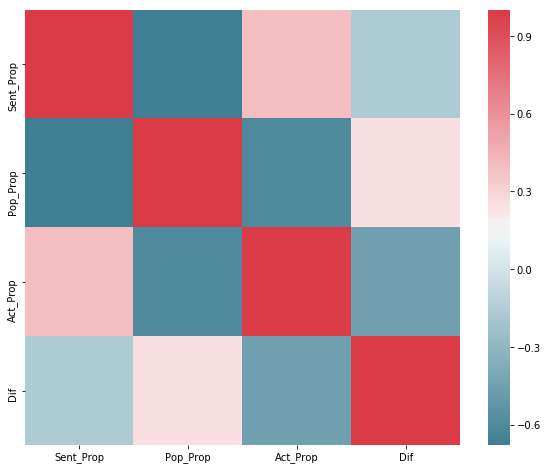

In [17]:
f, ax = plt.subplots(figsize=(10, 8))
corr = Train_coke_final.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


We see that there appears to be a strong negative correlation between the number of active users and stock price. We now construct our logistic regression model and test its preditive performance.

In [18]:
from sklearn.linear_model import LogisticRegression

In [20]:
logisticRegr = LogisticRegression()

XTrain = Train_coke_final[['Sent_Prop', 'Pop_Prop', 'Act_Prop']].values
yTrain = Train_coke_final[['Dif']].values
yTrain = yTrain.ravel()

logisticRegr.fit(XTrain, yTrain)

XTest = Test_coke_final[['Sent_Prop', 'Pop_Prop', 'Act_Prop']].values
yTest = Test_coke_final[['Dif']].values
yTest = yTest.ravel()

predictions = logisticRegr.predict(XTest)
coke_score = logisticRegr.score(XTest, yTest)
print("Accuracy:", coke_score)

Accuracy: 0.555555555556


We repeat a similar process for each company.

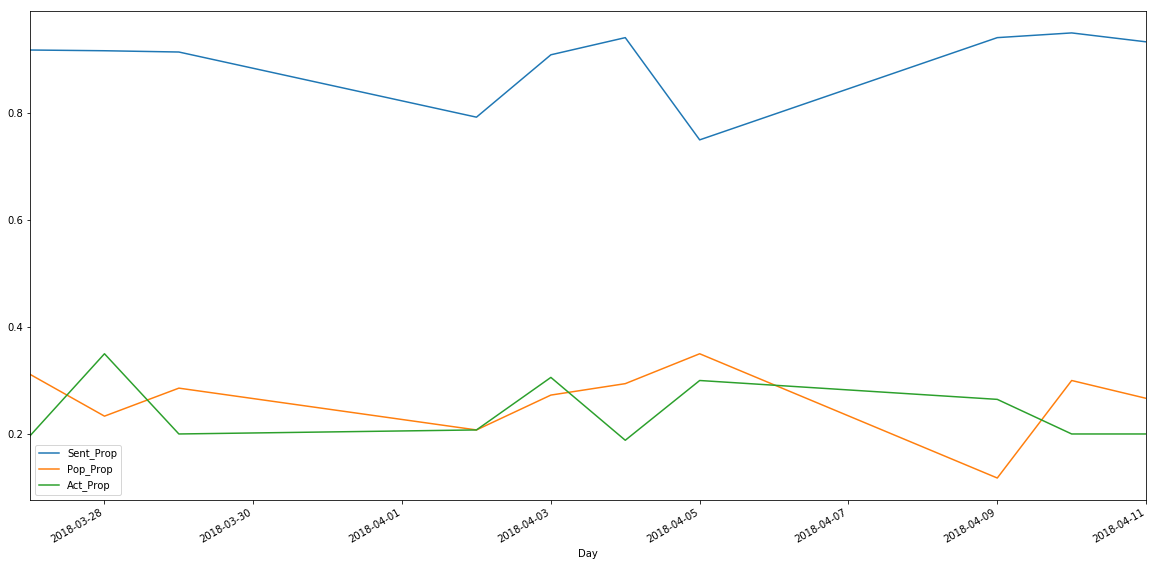

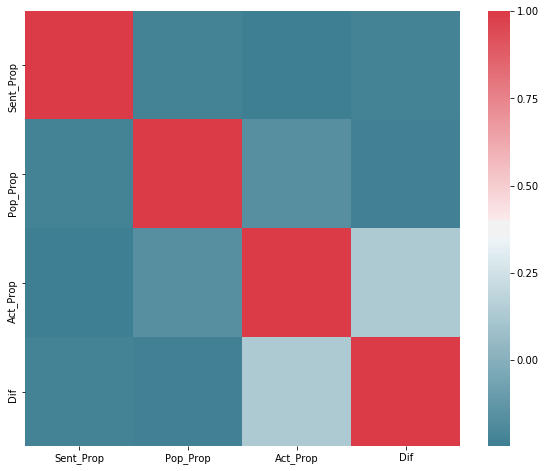

In [21]:
# Dr Pepper
drp_tweet_df = tweetdfs[dfkeys_tweets[1]]
drp_user_df = userdfs[dfkeys_users[1]] 

drp_tidy_data = get_tidy(drp_tweet_df, drp_user_df) 

Train_drp, Test_drp = t_split(drp_tidy_data)

# we aggragate our observations into daily proportions 

Train_drp_prp = tidy_prop(Train_drp)
Test_drp_prp = tidy_prop(Test_drp)

# we generate our yTrain and yTest and add them to our final df

drp_price_df = pd.read_csv("drp_price.csv")
drp_tidy_price = get_tidy_price(drp_price_df)

Train_drp_final = pd.merge(Train_drp_prp, drp_tidy_price, on='Day', how='inner')
Test_drp_final = pd.merge(Test_drp_prp, drp_tidy_price, on='Day', how='inner')

# visualization of proportions

Train_viz = Train_drp_final[['Day', 'Sent_Prop', 'Pop_Prop', 'Act_Prop']].copy()
Train_viz.plot(x='Day', figsize=(20,10))

# Correlation matrix

f, ax = plt.subplots(figsize=(10, 8))
corr = Train_drp_final.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [22]:
XTrain = Train_drp_final[['Sent_Prop', 'Pop_Prop', 'Act_Prop']].values
yTrain = Train_drp_final[['Dif']].values
yTrain = yTrain.ravel()

logisticRegr.fit(XTrain, yTrain)

XTest = Test_drp_final[['Sent_Prop', 'Pop_Prop', 'Act_Prop']].values
yTest = Test_drp_final[['Dif']].values
yTest = yTest.ravel()

predictions = logisticRegr.predict(XTest)
drp_score = logisticRegr.score(XTest, yTest)
print("Accuracy:", drp_score)

Accuracy: 0.7


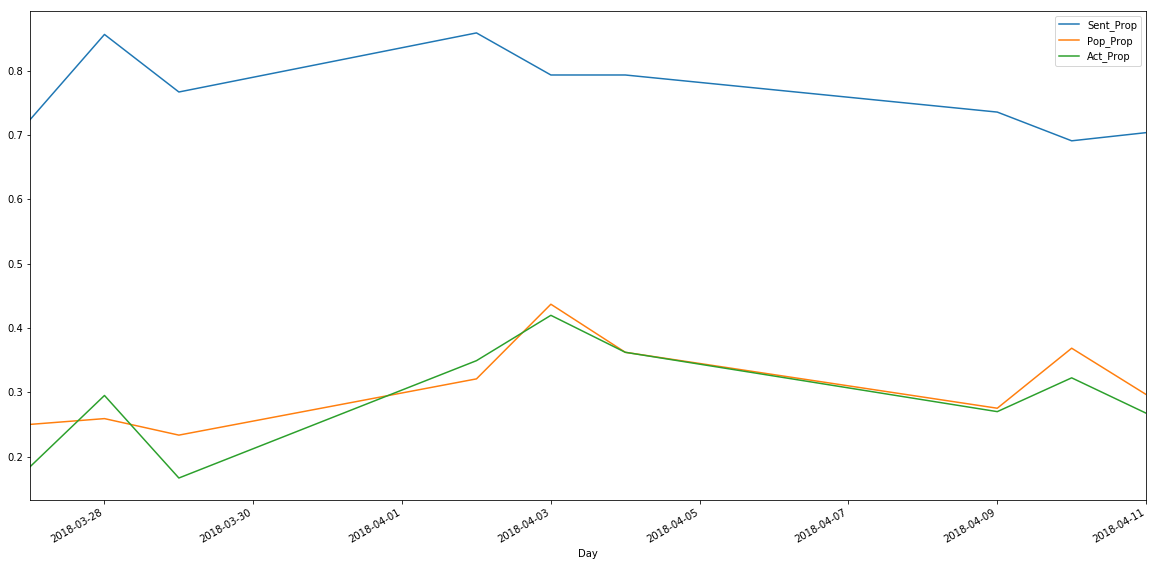

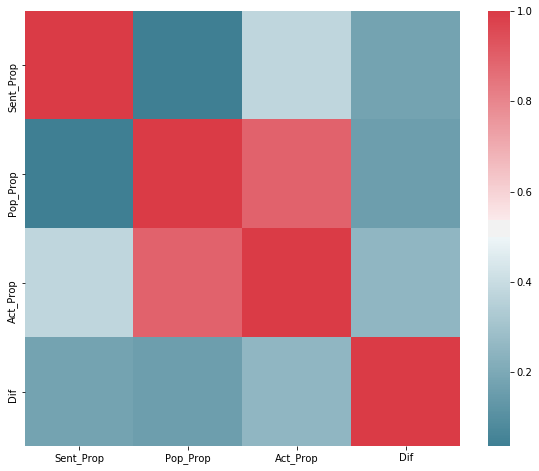

In [23]:
# Monster
monst_tweet_df = tweetdfs[dfkeys_tweets[2]]
monst_user_df = userdfs[dfkeys_users[2]] 

monst_tidy_data = get_tidy(monst_tweet_df, monst_user_df) 

Train_monst, Test_monst = t_split(monst_tidy_data)

# we aggragate our observations into daily proportions 

Train_monst_prp = tidy_prop(Train_monst)
Test_monst_prp = tidy_prop(Test_monst)

# we generate our yTrain and yTest and add them to our final df

monst_price_df = pd.read_csv("monst_price.csv")
monst_tidy_price = get_tidy_price(monst_price_df)

Train_monst_final = pd.merge(Train_monst_prp, monst_tidy_price, on='Day', how='inner')
Test_monst_final = pd.merge(Test_monst_prp, monst_tidy_price, on='Day', how='inner')

# visualization of proportions

Train_viz = Train_monst_final[['Day', 'Sent_Prop', 'Pop_Prop', 'Act_Prop']].copy()
Train_viz.plot(x='Day', figsize=(20,10))

# Correlation matrix

f, ax = plt.subplots(figsize=(10, 8))
corr = Train_monst_final.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [24]:
XTrain = Train_monst_final[['Sent_Prop', 'Pop_Prop', 'Act_Prop']].values
yTrain = Train_monst_final[['Dif']].values
yTrain = yTrain.ravel()

logisticRegr.fit(XTrain, yTrain)

XTest = Test_monst_final[['Sent_Prop', 'Pop_Prop', 'Act_Prop']].values
yTest = Test_monst_final[['Dif']].values
yTest = yTest.ravel()

predictions = logisticRegr.predict(XTest)
monst_score = logisticRegr.score(XTest, yTest)
print("Accuracy:", monst_score)

Accuracy: 0.666666666667


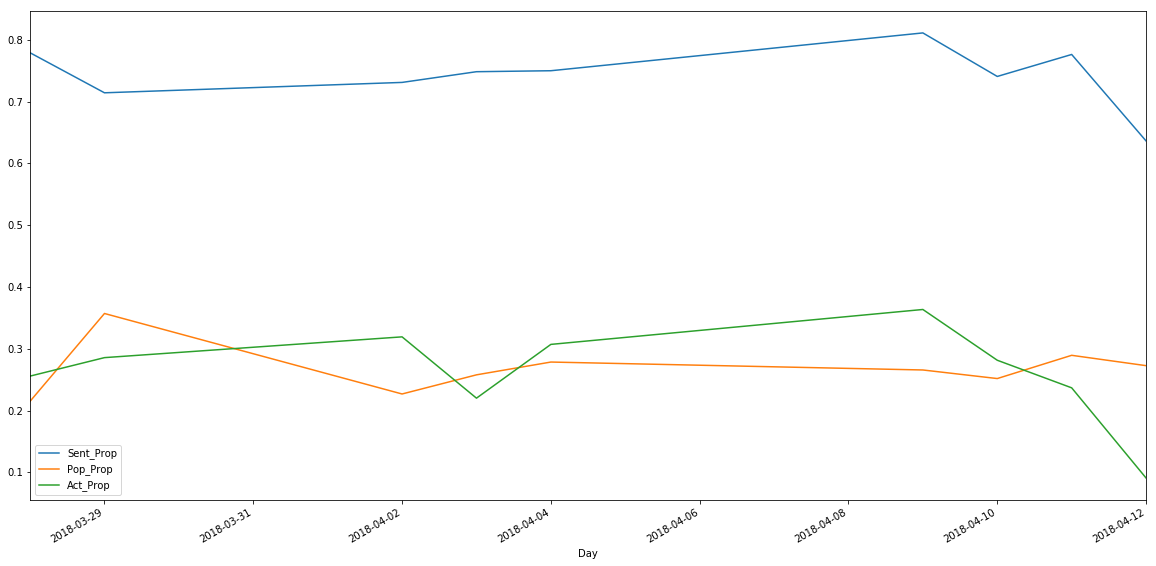

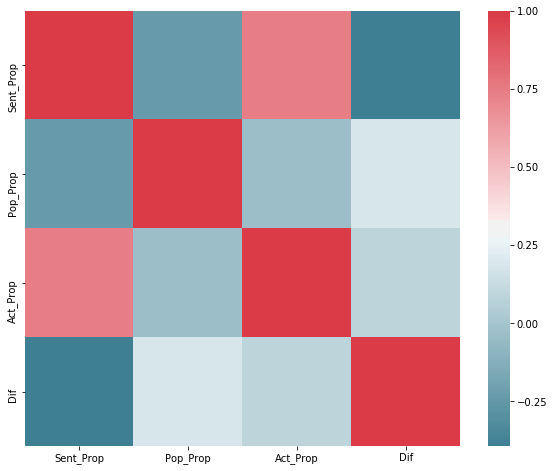

In [25]:
# Pepsi
pepsi_tweet_df = tweetdfs[dfkeys_tweets[3]]
pepsi_user_df = userdfs[dfkeys_users[3]] 

pepsi_tidy_data = get_tidy(pepsi_tweet_df, pepsi_user_df) 

Train_pepsi, Test_pepsi = t_split(pepsi_tidy_data)

# we aggragate our observations into daily proportions 

Train_pepsi_prp = tidy_prop(Train_pepsi)
Test_pepsi_prp = tidy_prop(Test_pepsi)

# we generate our yTrain and yTest and add them to our final df

pepsi_price_df = pd.read_csv("pepsi_price.csv")
pepsi_tidy_price = get_tidy_price(pepsi_price_df)

Train_pepsi_final = pd.merge(Train_pepsi_prp, pepsi_tidy_price, on='Day', how='inner')
Test_pepsi_final = pd.merge(Test_pepsi_prp, pepsi_tidy_price, on='Day', how='inner')

# visualization of proportions

Train_viz = Train_pepsi_final[['Day', 'Sent_Prop', 'Pop_Prop', 'Act_Prop']].copy()
Train_viz.plot(x='Day', figsize=(20,10))

# Correlation matrix

f, ax = plt.subplots(figsize=(10, 8))
corr = Train_pepsi_final.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [26]:
XTrain = Train_pepsi_final[['Sent_Prop', 'Pop_Prop', 'Act_Prop']].values
yTrain = Train_pepsi_final[['Dif']].values
yTrain = yTrain.ravel()

logisticRegr.fit(XTrain, yTrain)

XTest = Test_pepsi_final[['Sent_Prop', 'Pop_Prop', 'Act_Prop']].values
yTest = Test_pepsi_final[['Dif']].values
yTest = yTest.ravel()

predictions = logisticRegr.predict(XTest)
pepsi_score = logisticRegr.score(XTest, yTest)
print("Accuracy:", pepsi_score)

Accuracy: 0.5


### Summary of Analysis

As we can see from the above graphs and correlation matrices, there are significant differences in the relationships between the dependent and independent variables for each company. Not surprisingly, there are also significant differences in the predictive performances of the logistic models for each company. 

The model performed only as good as a random flip of a coin for both Coke and Pepsi, while achieving 70% and 67% accuracy for Dr. Pepper and Monster, respectively. Although we may be tempted to assume that Tweet object analysis may have greater predictive properties for Dr Pepper and Monster, a closer inspection of the activity of the stock price for each company for the time period under observation may shed some light on the matter. 

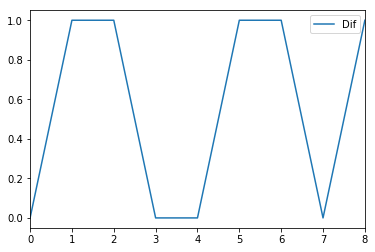

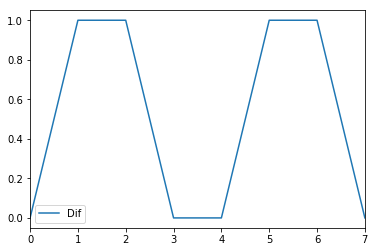

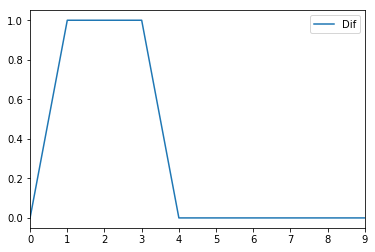

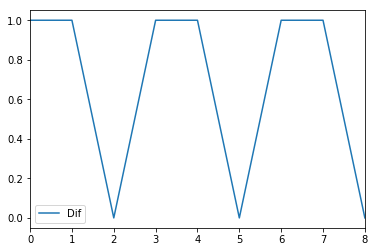

In [27]:
coke_prices = Test_coke_final[['Dif']].copy()
coke_prices.plot()

pepsi_prices = Test_pepsi_final[['Dif']].copy()
pepsi_prices.plot()

drp_prices = Test_drp_final[['Dif']].copy()
drp_prices.plot()

monst_prices = Test_monst_final[['Dif']].copy()
monst_prices.plot()

### Conclusion

Although we see the stock price for Dr. Pepper was consistently more stable than the other three stocks, we note that Monster, whose model achieved 67% accuracy, was as equally volitile as Coke and Pepsi. We must be cautious though. The accuracy of the model only points to a possible correlation between Tweet objects and price, and does not imply a causal relationship between the two.

A very interesting observation is the difference in the relationships between the independent variables across all four companies. Again, we can only speculate as to the cause of these relationships, but it is obvious that each company is pursuing a very different marketing strategy through Twitter. These difference are visually very obvious when we evaluate their respective correlation matrices. 

Looking back at our experiences in completing this projects, there are a few choices that we would made differently. First, we would have chosen a different dependent variable. Not until we had progressed significantly into collecting and processing the Tweets did we realize that they could only be reduced to a granuality of 15 min intervals, making it rather difficult to assign one observation to each Tweet object. Instead, we would have chosen some attribute of the Tweet, perhaps text sentiment, as the dependent variable, and another set of Tweet object attributes as independent variables. 

Alternatively, we would have begun collecting Tweets at a much earlier stage in the process. Although we felt we had a good amount of raw data, when we reduced it to daily proportions, the number of observations was reduced significantly, calling into question the accuracy of our logistic regression model. 